In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [96]:
df = pd.read_csv('../../data/normalized_tweets.csv')
#Droppare colonne other cyberbullying???
#df = df[df['cyberbullying_type'] != 'other_cyberbullying']

# Multiclass Naive Bayes Classifier

Function to perform cross validation.

In [97]:
def train_evaluate_model(df, text_column, label_column, vectorizer, classifier, title, n_splits=5, binary = False):
    # Extract features and labels
    X = df[text_column]
    y = df[label_column]

    if binary:
        y = y.astype('int')
    
    # Vectorize text data
    X_tfidf = vectorizer.fit_transform(X)
    
    # Define K-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    # Lists to store F1 scores for each fold
    f1_scores = []
    
    # Lists to store predicted and true labels for confusion matrix
    y_true_all = []
    y_pred_all = []
    
    # Perform K-fold cross-validation
    for train_index, test_index in kfold.split(X_tfidf):
        X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train classifier
        classifier.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = classifier.predict(X_test)
        
        # Calculate F1 score and accuracy
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Append score to lists
        f1_scores.append(f1)
        
        # Append true and predicted labels
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    # Calculate mean F1 score and accuracy across all folds
    mean_f1_score = np.mean(f1_scores)
    
    # Print mean scores
    print("Mean F1 Score:", mean_f1_score)
    
    # Generate classification report
    print(classification_report(y_true_all, y_pred_all))
    
    # Get the sorted list of unique class labels
    classes = sorted(df[label_column].unique())
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all, labels=classes)
    
    # Plot confusion matrix with title
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Multinomial Naive Bayes Model
- Designed for discrete count-based data (e.g., text data represented by word frequency).	
- Features are counts of occurrences in different classes.
- Text classification, document categorization, sentiment analysis.

Mean F1 Score: 0.7136582946871479
                     precision    recall  f1-score   support

                age       0.69      0.98      0.81      7992
          ethnicity       0.82      0.91      0.86      7958
             gender       0.81      0.82      0.81      7906
  not_cyberbullying       0.66      0.34      0.45      7816
other_cyberbullying       0.61      0.38      0.47      7613
           religion       0.77      0.97      0.86      7996

           accuracy                           0.74     47281
          macro avg       0.72      0.74      0.71     47281
       weighted avg       0.73      0.74      0.71     47281



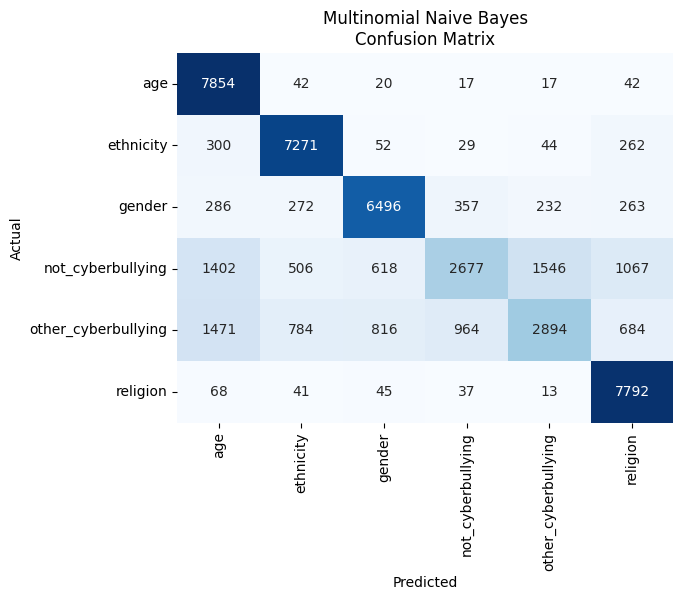

In [98]:

vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
title = 'Multinomial Naive Bayes\nConfusion Matrix'
train_evaluate_model(df, 'tweet_text', 'cyberbullying_type', vectorizer, classifier, title)


## Complement Naive Bayes Model
- Designed for categorical data with imbalanced classes.
- Features are represented by attribute frequencies in documents.
- Useful when classes are imbalanced and training data is limited.
- Used in text classification, document categorization, and reviews analysis applications.

Mean F1 Score: 0.7245515221445991
                     precision    recall  f1-score   support

                age       0.74      0.98      0.84      7992
          ethnicity       0.81      0.93      0.87      7958
             gender       0.81      0.81      0.81      7906
  not_cyberbullying       0.63      0.36      0.46      7816
other_cyberbullying       0.59      0.41      0.48      7613
           religion       0.78      0.98      0.87      7996

           accuracy                           0.75     47281
          macro avg       0.73      0.74      0.72     47281
       weighted avg       0.73      0.75      0.72     47281



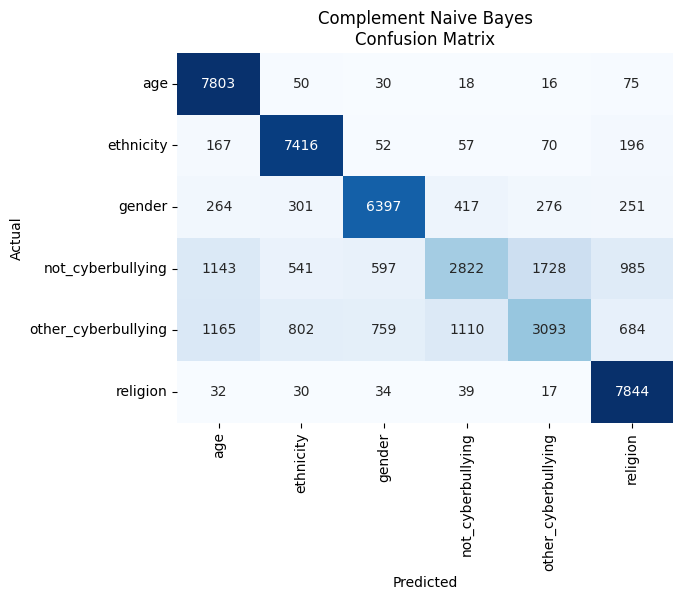

In [99]:
vectorizer = TfidfVectorizer()
classifier = ComplementNB()
title = 'Complement Naive Bayes\nConfusion Matrix'
train_evaluate_model(df, 'tweet_text', 'cyberbullying_type', vectorizer, classifier, title)

## Bernoulli Naive Bayes Model

- Designed for discrete count-based data, such as text data represented by word frequency.
- Features are counts of occurrences in different classes.
- Commonly used in text classification, document categorization, and sentiment analysis tasks.

Mean F1 Score: 0.8043849303209075
                     precision    recall  f1-score   support

                age       0.95      0.96      0.95      7992
          ethnicity       0.96      0.92      0.94      7958
             gender       0.92      0.73      0.82      7906
  not_cyberbullying       0.57      0.52      0.55      7816
other_cyberbullying       0.55      0.75      0.63      7613
           religion       0.93      0.92      0.92      7996

           accuracy                           0.80     47281
          macro avg       0.81      0.80      0.80     47281
       weighted avg       0.82      0.80      0.80     47281



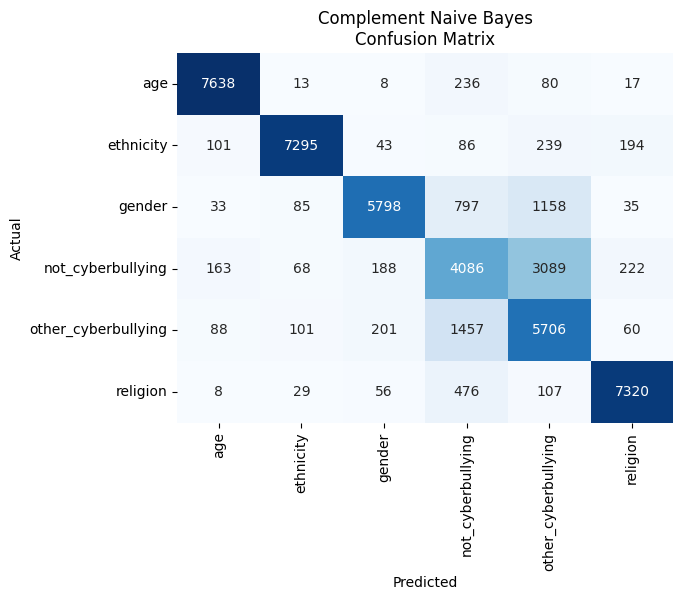

In [100]:
vectorizer = TfidfVectorizer()
classifier = BernoulliNB()
title = 'Complement Naive Bayes\nConfusion Matrix'
train_evaluate_model(df, 'tweet_text', 'cyberbullying_type', vectorizer, classifier, title)

# Binary Naive Bayes Classifier

From the original dataset, we selected all the tweets labeled as "not_cyberbullying" and assigned them the category 1. Since there were 7815 such tweets, to achieve a balanced distribution, we selected 1563 tweets for each cyberbullying category and assigned them label 0.

In [102]:
df = pd.read_csv('../../data/normalized_tweets.csv')

# if we drop 'other_cyberbullyng', n changes
# df = df[df['cyberbullying_type'] != 'other_cyberbullying']
# n = 1953

n = 1563

# Create an empty dataframe for the results
result_df = pd.DataFrame(columns=['tweet_text', 'label'])


for category in df['cyberbullying_type'].unique():
    if category != 'not_cyberbullying':
        sampled_df = df[df['cyberbullying_type'] == category].sample(n=n, replace=False)
        sampled_df.loc[:, 'label'] = 0  
        result_df = pd.concat([result_df, sampled_df[['tweet_text', 'label']]], ignore_index=True)
    else:
        other_cyberbullying_df = df[df['cyberbullying_type'] == category].copy() 
        other_cyberbullying_df.loc[:, 'label'] = 1 
        result_df = pd.concat([result_df, other_cyberbullying_df[['tweet_text', 'label']]], ignore_index=True)


## Multinomial Naive Bayes Model

Mean F1 Score: 0.7408153170535268
              precision    recall  f1-score   support

           0       0.70      0.87      0.77      7815
           1       0.82      0.62      0.71      7816

    accuracy                           0.74     15631
   macro avg       0.76      0.74      0.74     15631
weighted avg       0.76      0.74      0.74     15631



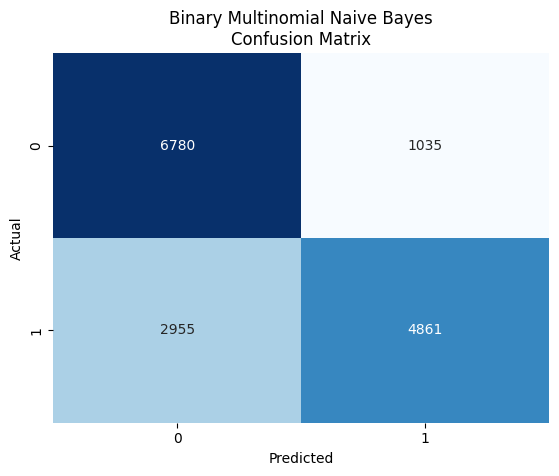

In [103]:
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
title = 'Binary Multinomial Naive Bayes\nConfusion Matrix'
train_evaluate_model(result_df, 'tweet_text', 'label', vectorizer, classifier, title, binary = True)

## Complement Naive Bayes Model

Mean F1 Score: 0.7423098250704211
              precision    recall  f1-score   support

           0       0.70      0.87      0.77      7815
           1       0.83      0.62      0.71      7816

    accuracy                           0.75     15631
   macro avg       0.76      0.75      0.74     15631
weighted avg       0.76      0.75      0.74     15631



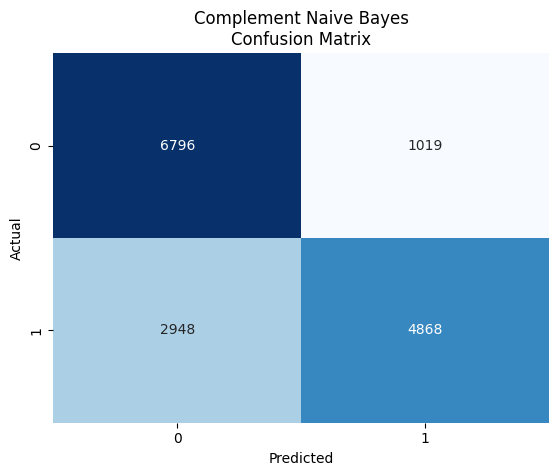

In [104]:
vectorizer = TfidfVectorizer()
classifier = ComplementNB()
title = 'Complement Naive Bayes\nConfusion Matrix'
train_evaluate_model(result_df, 'tweet_text', 'label', vectorizer, classifier, title, binary = True)

## Bernoulli Naive Bayes Model

Mean F1 Score: 0.815951668332459
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      7815
           1       0.77      0.89      0.83      7816

    accuracy                           0.82     15631
   macro avg       0.82      0.82      0.82     15631
weighted avg       0.82      0.82      0.82     15631



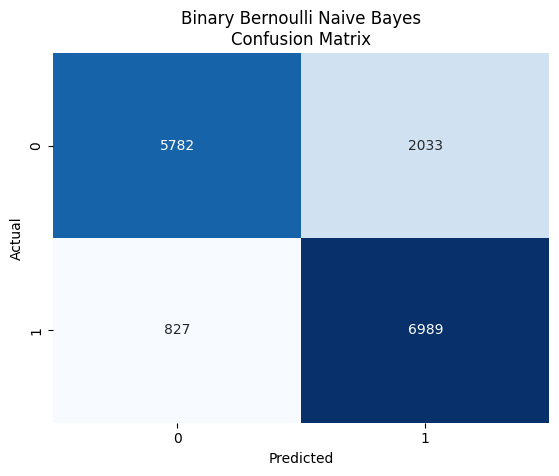

In [105]:
vectorizer = TfidfVectorizer()
classifier = BernoulliNB()
title = 'Binary Bernoulli Naive Bayes\nConfusion Matrix'
train_evaluate_model(result_df, 'tweet_text', 'label', vectorizer, classifier, title, binary = True)